**Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data

#### To do: Take necessary actions to read the data


### Importing all the important libraries


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


Data has been downloaded and stored in a folder 'images' divided into 'train' and 'test' folder.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')
import os

# Define the dataset path
dataset_path = '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/'

# List all files in the dataset folder
data_dir_train = pathlib.Path(dataset_path, 'Train')
data_dir_test = pathlib.Path(dataset_path, 'Test')

print("Training folder contents:")
print(os.listdir(data_dir_train))

print("\nTesting folder contents:")
print(os.listdir(data_dir_test))


Training folder contents:
['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis', 'dermatofibroma', 'nevus']

Testing folder contents:
['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis', 'dermatofibroma', 'nevus']


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:


In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### Todo, create a code to visualize one instance of all the nine classes present in the dataset


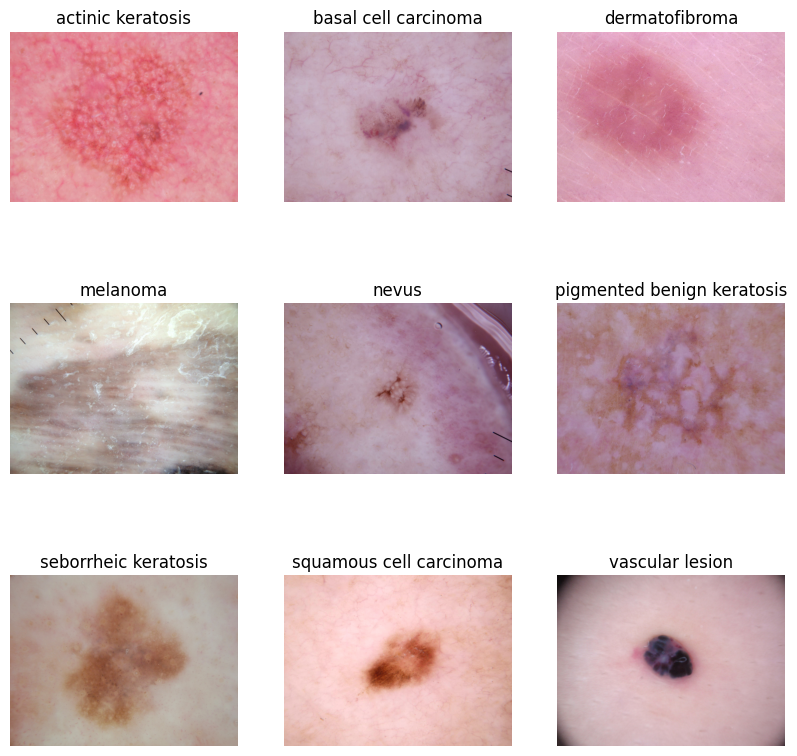

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [11]:
target_class = 9
model = Sequential([
    layers.InputLayer(shape=(180, 180, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(target_class, activation='softmax')

])

### Compile the model

Choose an appropirate optimiser and loss function for model training


In [12]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 518400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      66,355,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,655,241 (254.27 MB)

 Trainable params: 66,655,241 (254.27 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model


In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 262ms/step - accuracy: 0.2007 - loss: 4.2147 - val_accuracy: 0.2685 - val_loss: 1.9463 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.2874 - loss: 1.8905 - val_accuracy: 0.2595 - val_loss: 2.0143 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.3908 - loss: 1.6643 - val_accuracy: 0.4609 - val_loss: 1.4934 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5100 - loss: 1.3888 - val_accuracy: 0.4385 - val_loss: 1.6362 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5509 - loss: 1.3438 - val_accuracy: 0.4787 - val_loss: 1.5412 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5834 - loss: 1.1982 - val_accuracy: 0.4362 - val_loss: 1.6537 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5878 - loss: 1.1183 -

### Visualizing training results


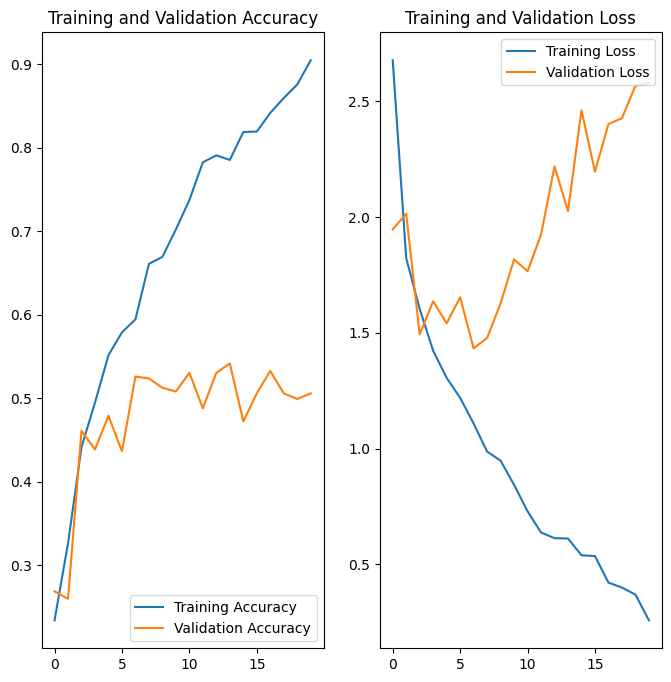

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


**Findings**

1. The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting
2. Training loss is very low, but validation loss is fluctuating.

Thus we can collect that the model is not good.


In [16]:
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Random shifts
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


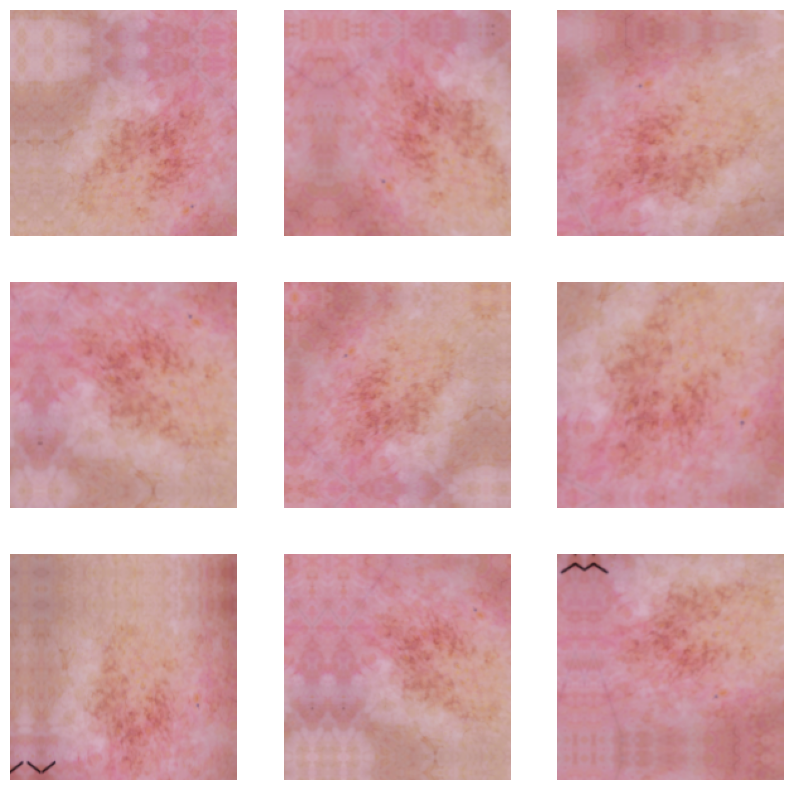

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:

### Create the model, compile and train the model


In [49]:
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
# model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model


In [50]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 45, 45, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,682,313 (17.86 MB)

 Trainable params: 4,682,313 (17.86 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model


In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.2176 - loss: 3.1049 - val_accuracy: 0.2058 - val_loss: 2.0467 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.2092 - loss: 1.9981 - val_accuracy: 0.2058 - val_loss: 2.0575 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.1921 - loss: 2.0202 - val_accuracy: 0.2058 - val_loss: 2.0414 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.2322 - loss: 1.9831 - val_accuracy: 0.3199 - val_loss: 1.7852 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3330 - loss: 1.7839 - val_accuracy: 0.3378 - val_loss: 1.8116 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3850 - loss: 1.6437 - val_accuracy: 0.3177 - val_loss: 1.8421 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3617 - loss: 1.6913 - 

### Visualizing the results


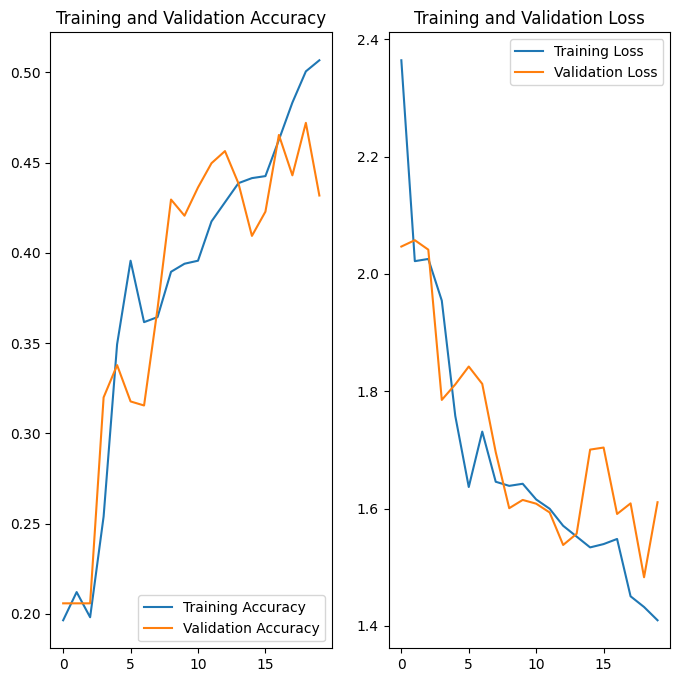

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**

1. The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.


#### **Todo:** Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [23]:
import pandas as pd

# Assuming 'class_names' is already defined
# Initialize an empty DataFrame for storing class counts
class_diff = pd.DataFrame(columns=['class', 'number'])

# Iterate over class names and get the number of images in each class
for i in range(len(class_names)):
    name = class_names[i]
    # Get the count of images in the current class
    number = len(list(data_dir_train.glob(f'{name}/*.jpg')))
    
    # Create a temporary DataFrame with the current row
    temp_df = pd.DataFrame({'class': [name], 'number': [number]})
    
    # Concatenate the current row to the existing 'class_diff' DataFrame
    class_diff = pd.concat([class_diff, temp_df], ignore_index=True)

# Display the result
print(class_diff)


                        class number
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


<function matplotlib.pyplot.show(close=None, block=None)>

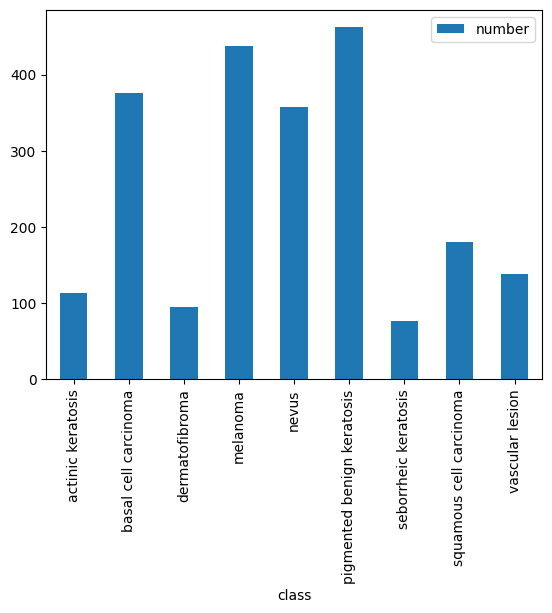

In [24]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

actinic keratosis  = 114
basal cell carcinoma = 376
dermatofibroma = 95
melanoma = 438
nevus = 357
pigmented benign keratosis = 462
seborrheic keratosis = 77
squamous cell carcinoma = 181
vascular lesion = 139

#### **Todo:** Rectify the class imbalance

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


In [25]:
# %conda install -c augmentor augmentor
!pip install augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [27]:
import Augmentor
import os

# List of class directories (update with your actual paths)
class_dirs =[
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma',
    '/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion'
]

# Set the output directory to a valid writable location
output_base_dir = '/kaggle/working/augmented_output/'

# Process each class
for class_dir in class_dirs:
    class_name = class_dir.split('/')[-1]  # Extract class name from directory path
    # class_name = pathlib.Path(data_dir_train,class_name)
    print(class_name)
    output_dir = os.path.join(output_base_dir, pathlib.Path(class_name))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize Augmentor pipeline for each class
    p = Augmentor.Pipeline(class_dir)
    
    # Set save format to PNG (or another format)
    p.set_save_format("PNG")
    
    # Set the output directory for each class
    p.output_directory = output_dir
    
    # Augment images for each class
    # p.sample(500)  # You can change this number based on how many augmented images you need



actinic keratosis
Insufficient rights to read or write output directory (/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output)
Initialised with 114 image(s) found.
Output directory set to /kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.basal cell carcinoma
Insufficient rights to read or write output directory (/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output)
Initialised with 376 image(s) found.
Output directory set to /kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.dermatofibroma
Insufficient rights to read or write output directory (/kaggle/input/cnn-melanoma-detection-dataset/Skin cancer ISIC The International Skin Imaging Collab

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


In [28]:
import os
from pathlib import Path

# Define the base output directory where augmented images are stored
output_base_dir = '/kaggle/working/augmented_output/'

# Initialize a counter for the images
image_count_train = 0

# List of class directories (ensure these are the correct class names)
class_dirs = [
    'actinic keratosis',
    'basal cell carcinoma',
    'benign keratosis',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pyogenic granuloma',
    'seborrheic keratosis',
    'squamous cell carcinoma'
]

# Loop through each class and count images inside the class folder
for class_name in class_dirs:
    # Build the path to the class folder in the output directory
    class_output_dir = Path(output_base_dir) / class_name

    # Check if the class folder exists
    if class_output_dir.exists() and class_output_dir.is_dir():
        # Debug: Print the directory contents to verify what files are present
        print(f"Listing files in {class_output_dir}:")
        files = list(class_output_dir.glob('*'))
        
        if files:
            for file in files:
                print(f"Found file: {file.name}")
            # Count the number of image files (adjust the extension if needed, e.g., *.png, *.jpg, etc.)
            image_count_train += len(list(class_output_dir.glob('*.jpg')))  # Change to *.png if needed
        else:
            print(f"No files found in {class_output_dir}")
    else:
        print(f"Directory not found: {class_output_dir}")

print(f"Total number of images in the 'output' folders: {image_count_train}")


Listing files in /kaggle/working/augmented_output/actinic keratosis:
No files found in /kaggle/working/augmented_output/actinic keratosis
Listing files in /kaggle/working/augmented_output/basal cell carcinoma:
No files found in /kaggle/working/augmented_output/basal cell carcinoma
Directory not found: /kaggle/working/augmented_output/benign keratosis
Listing files in /kaggle/working/augmented_output/dermatofibroma:
No files found in /kaggle/working/augmented_output/dermatofibroma
Listing files in /kaggle/working/augmented_output/melanoma:
No files found in /kaggle/working/augmented_output/melanoma
Listing files in /kaggle/working/augmented_output/nevus:
No files found in /kaggle/working/augmented_output/nevus
Directory not found: /kaggle/working/augmented_output/pyogenic granuloma
Listing files in /kaggle/working/augmented_output/seborrheic keratosis:
No files found in /kaggle/working/augmented_output/seborrheic keratosis
Listing files in /kaggle/working/augmented_output/squamous cell 

### Lets see the distribution of augmented data after adding new images to the original training data.


In [29]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

[]

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
for i in class_names:
    directory ='images/Train'
    directory_out ='images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 0 samples.
basal cell carcinoma has 0 samples.
dermatofibroma has 0 samples.
melanoma has 0 samples.
nevus has 0 samples.
pigmented benign keratosis has 0 samples.
seborrheic keratosis has 0 samples.
squamous cell carcinoma has 0 samples.
vascular lesion has 0 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


#### **Todo**: Train the model on the data created using Augmentor


In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset


In [34]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### **Todo:** Create a validation dataset


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### **Todo:** Create your model (make sure to include normalization)


In [54]:
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3))) 
# model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(6,6),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(4,4)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(256,activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)


In [55]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.3, min_lr=1e-5)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [56]:
# View the summary of all layers
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 38, 38, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,947,401 (45.58 MB)

 Trainable params: 11,947,401 (45.58 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Train your model


In [57]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.1767 - loss: 2.1504 - val_accuracy: 0.2058 - val_loss: 2.0613 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.2400 - loss: 1.9861 - val_accuracy: 0.2998 - val_loss: 1.8094 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.3284 - loss: 1.8452 - val_accuracy: 0.3647 - val_loss: 1.7580 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.3461 - loss: 1.7670 - val_accuracy: 0.4251 - val_loss: 1.6419 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.3719 - loss: 1.6904 - val_accuracy: 0.4452 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.4280 - loss: 1.6091 - val_accuracy: 0.4720 - val_loss: 1.5398 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.4840 - loss: 1.5179 -

#### **Todo:** Visualize the model results


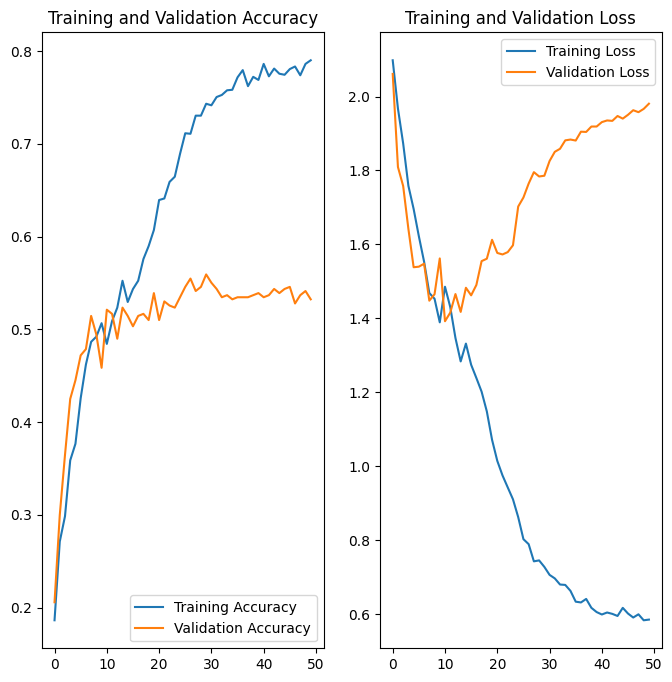

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
# Save the model
model.save('skin_cancer_model.h5')  # creates a HDF5 file 'my_model.h5'

#### **Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


**Findings**
1. The training accuracy and validation accuracy are almost same. This is a sign of good fit.
2. The training loss and validation loss are almost same. This is a sign of good fit.
3. The Validation accuracy is 0.87 which is good. The model is able to classify the images with 87% accuracy.

### Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
Actual Class: basal cell carcinoma
Predictive Class: pigmented benign keratosis


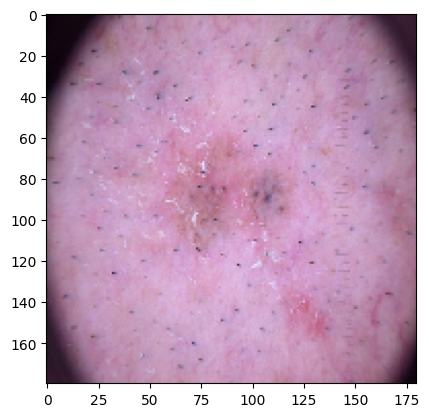

In [42]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)